In [1]:
from colormath import color_objects, color_conversions
import os
import sys
import pandas as pd
import matplotlib
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
import tqdm

# Get relatives

sys.path.append('/Users/benpeloquin/Desktop/Projects/world_color_survey/')
sys.path.append('/Users/benpeloquin/Desktop/Projects/world_color_survey/data')
import utils
from data import data

%matplotlib inline

In [2]:
def normalize_rows(M):
    """Noramlze across columns (rows sum to 1)"""
    total = np.sum(M, axis=1)
    return (M.transpose() / total).transpose()

def normalize_cols(M):
    """Normalize down rows (columns sum to 1)"""
    total = np.sum(M, axis=0)
    return M / total

def rsa_speaker(M, depth=0):
    M_ = normalize_cols(M)
    for d in range(depth):
        M_ = normalize_cols(normalize_rows(M_))
    return M_
        
def rsa_listener(M, depth=0):
    M_ = normalize_rows(M)
    for d in range(depth):
        M_ = normalize_rows(normalize_cols(M_))
    return M_

In [3]:
fp = '../data/merged_wcs_data.csv'
df_raw = pd.read_csv(fp)

# Quick check of WCS

In [37]:
df_terms = data.input_data(utils.term_url, utils.term_names, utils.term_dtypes)
df_chips = data.input_data(utils.chip_url, utils.chip_names, utils.chip_dtypes)
df_colors = data.input_data(utils.colors_url, utils.color_names, utils.color_dtypes, [0])

In [39]:
df_raw = pd.merge(pd.merge(df_terms, df_chips, on=['chip_num']), df_colors, on=['chip_num'])

In [40]:
df_agg = df_raw[['lang_num', 'term_abbr', 'chip_num', 'speaker_num']] \
    .groupby(['lang_num', 'term_abbr', 'chip_num']) \
    .sum() \
    .rename(columns={'speaker_num': 'cnt'}) \
    .reset_index()

Gibson 2017 analysis:
$$S(c) = \sum_w p(w|c)log_2(\frac{1}{p(c|w)})$$
$$ES = \sum_c p(c)S(c)$$

In [4]:
def get_term_chip_cnt(term, chip, df):
    vals = df[(df['term_abbr'] == term) & (df['chip_num'] == chip)]['cnt'].values
    if len(vals) != 0:
        return vals[0]
    else:
        return 0
    
def create_count_df(lang_num, df):
    """Full df to filtered lang_num df to counts df."""
    df_cnts = df[df['lang_num'] == lang_num][['speaker_num', 'term_abbr', 'chip_num']] \
        .groupby(['term_abbr', 'chip_num']) \
        .sum() \
        .rename(columns={'speaker_num': 'cnt'}) \
        .reset_index()
    return df_cnts
    
def create_term_chip_matrix(lang_num):
    """Create a term-chip raw count matrix.
    
    Term X Chip matrix
    
    Returns
    -------
    tuple of np.array, list, list
        Matrix, terms, chips
    """
    df_curr = df_agg[df_agg['lang_num'] == lang_num]
    terms = set(df_curr['term_abbr'].values)
    chips = set(df_curr['chip_num'].values)
    d_res = []
    for term in terms:
        curr_row = [get_term_chip_cnt(term, chip, df_curr) for chip in chips]
        d_res.append(curr_row) 
    return np.array(d_res), terms, chips

In [20]:
M1, terms1, chips1 = create_term_chip_matrix(1)

In [21]:
M1_speaker = normalize_cols(M1)
M1_listener = normalize_rows(M1)

In [5]:
def log2_(v):
    return np.log2(v) if v != 0. else 0.

def p_c_given_w(M_listener, w, c):
    assert abs(np.sum(M_listener[w, :]) - 1.) < 1e-05
    return M_listener[w, c]

def p_w_given_c(M_speaker, w, c):
    assert abs(np.sum(M_speaker[:, c]) - 1.) < 1e-05
    return M_speaker[w, c]

def s_c(M_listener, M_speaker, c):
    assert M_listener.shape == M_speaker.shape
    res = []
    for w in range(M_speaker.shape[0]):
        d = p_w_given_c(M_speaker, w, c) * log2_(p_c_given_w(M_listener, w, c))
        res.append(d)
    return np.sum(res)

def expected_surprisal(M_listener, M_speaker):
    assert M_listener.shape == M_speaker.shape
    scores = []
    for c in range(M_speaker.shape[1]):
        scores.append(s_c(M_listener, M_speaker, c))
    return -np.mean(scores)  # note we assume p_C is uniform

# Expected surprisal by vocab size

In [99]:
N_LANGUAGES = 10

In [100]:
languages = list(set(df_agg['lang_num'].values))

In [103]:
depths = range(1, 11)
d_results = []
for lang_num in tqdm.tqdm(languages[:N_LANGUAGES]):
    M, terms, chips = create_term_chip_matrix(lang_num)
    for d in depths:
        M_listener = rsa_listener(M, d)
        M_speaker = rsa_speaker(M, d)
        ES = expected_surprisal(M_listener, M_speaker)
        res = {
            'lang_num': lang_num,
            'n_terms': len(terms),
            'n_chips': len(chips),
            'depth': d,
            'ES': ES
        }
        d_results.append(res)
df_results = pd.DataFrame(d_results)


  0%|          | 0/10 [00:00<?, ?it/s]
Exception in thread Thread-15:
Traceback (most recent call last):
  File "/Users/benpeloquin/anaconda/envs/analysis/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/Users/benpeloquin/anaconda/envs/analysis/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/benpeloquin/anaconda/envs/analysis/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 10/10 [01:22<00:00,  8.25s/it]


In [ ]:
# df_results.to_csv("expected_surprisal_analysis_all_langs.csv")

In [105]:
df_results = df_results \
    .sort_values(by=['depth', 'ES'])

In [106]:
# sns.pointplot(x='n_terms', y='ES', hue='lang_num', size=10, scatter_kws={"s": 200, 'alpha':0.3}, data=df_results)
# plt.title('Gibson Expected surprisal across WCS languages')
# plt.ylabel('ES')
# plt.xlabel('Number of color terms')
# plt.xticks(rotation=90)

Text(0.5,0,'Number of color terms')

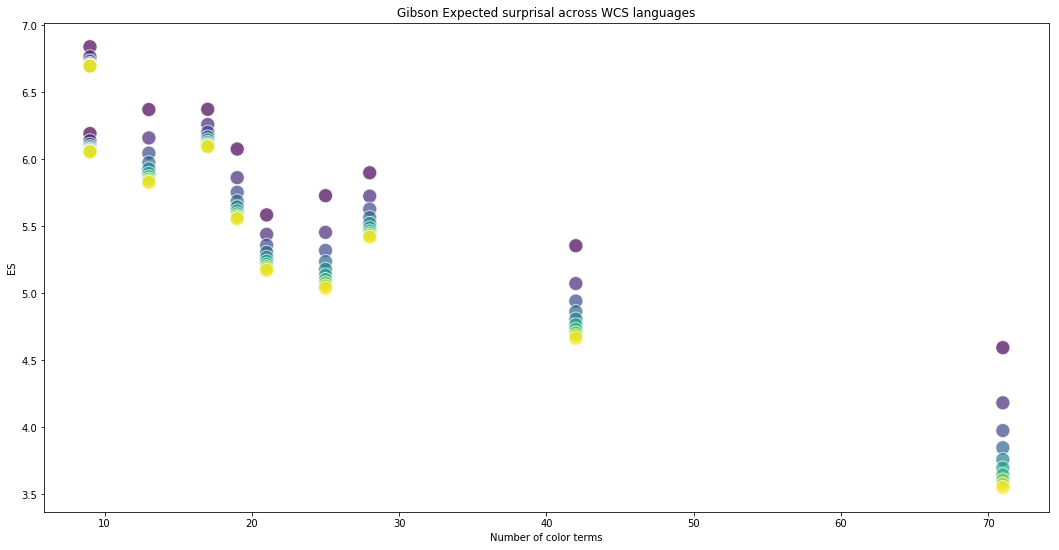

In [109]:
plt.figure(figsize=(18, 9))
plt.scatter(df_results['n_terms'].values, df_results['ES'].values, c=df_results['depth'].values, alpha=0.7, edgecolor='w', s=200)    
plt.title('Gibson Expected surprisal across WCS languages')
plt.ylabel('ES')
plt.xlabel('Number of color terms')

# Rank order communicative efficiency plot

In [6]:
"""Color conversion."""
df_colors = df_raw[['chip_num', 'L', 'A', 'B']].drop_duplicates().reset_index(drop=True)
def chip2lab(chip_num):
    vals = df_colors[df_colors['chip_num']==chip_num].values[0]
    L, a, b = vals[1], vals[2], vals[3]
    return L, a, b

def lab2rgb(L, a, b):
    """Convert a single cielab to rgb."""
    lab_color = color_objects.LabColor(lab_l=L, lab_a=a, lab_b=b)
    rgb_color = color_conversions.convert_color(lab_color, color_objects.AdobeRGBColor)
    return rgb_color.get_value_tuple()

def chip2rgb(chip_num):
    """Map a WCS chip to an RGB tuple."""
    L, a, b = chip2lab(chip_num)
    R, G, B = lab2rgb(L, a, b)
    return R, G, B

def test_clab(chip_num):
    """Purely testing functionality."""
    r, g, b = chip2rgb(chip_num)
    fig, ax = plt.subplots(figsize=(2, 2))
    x = np.array([r, g, b]).reshape(1, 1, 3)
    ax.imshow(x)

In [111]:
rgb_store = []
depths = range(0, 1, 1)
d_results = []
lang_nums_used = []
min_chips = 330
for lang_num in tqdm.tqdm(languages[:N_LANGUAGES]):
    min_x = np.inf
    M, terms, chips = create_term_chip_matrix(lang_num)
    M_listener = rsa_listener(M, 1)  # Gibson (2017) P(c|w)
    M_speaker = rsa_speaker(M, 0)    # Gibson (2017) P(w|c)
    # surprisal scores
    s_cs = [s_c(M_listener, M_speaker, i) for i, c in enumerate(chips)]
    # RGBs
    chip_rgbs = [chip2rgb(c) for c in chips]
    chip_rgbs = np.array([[r, g, b] for r, g, b in chip_rgbs])
    # IMPORTANT (BP): Sort colors by surprisal
    sorted_data = sorted(list(zip(s_cs, chip_rgbs)), key=lambda x: x[0], reverse=True)
    sorted_rgbs = np.array([rgb for _, rgb in sorted_data])
    if sorted_rgbs.shape[0] < min_chips:
        continue
    sorted_rgbs = sorted_rgbs[:min_chips, :]
    rgb_store.append(sorted_rgbs)
    lang_nums_used.append(lang_num)
M_rgb = np.stack(rgb_store)

100%|██████████| 10/10 [01:16<00:00,  7.64s/it]


In [94]:
# with open("rank_order_plot_data.pickle", 'wb') as f:
#     pickle.dump(rgb_store, f)

This was a little complicated, but we want to sort both the suprisal values as well as the languages.

In [10]:
def create_rank_order_plot(df_res, rgb_store, depth=1):
    if depth in df_res.columns:
        df_res = df_res[df_res['depth']==depth].sort_values(by=['ES'])
        
    # Sort
    # df_results values have been sorted by average surprisal ES
    idxs = np.array([v for v in df_res["lang_num"].values]).argsort()
    rgb_store = np.array(rgb_store)  # have to convert to np array
    # sort
    rgb_store = rgb_store[idxs]
    M_rgb = np.stack(rgb_store)
    
    # Plot
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.imshow(M_rgb, interpolation='nearest')
    ax.set_xlabel('Rank order surprisal')
    ax.set_ylabel('Language (Ordered by overall efficiency)')

In [11]:
create_rank_order_plot(df_results, rgb_store, depth=9)

NameError: name 'df_results' is not defined

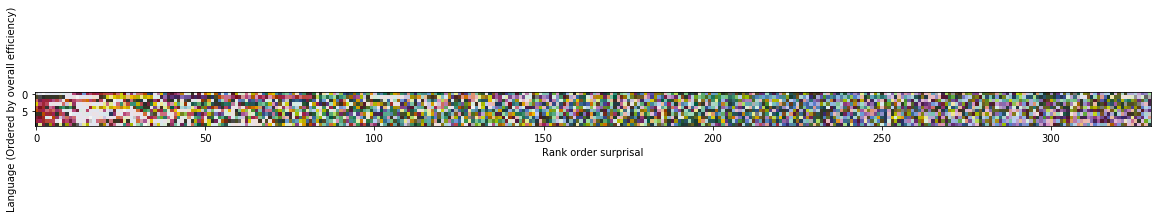

In [121]:
create_rank_order_plot(df_results, rgb_store, depth=1)

# Cached full WCS data

In [12]:
with open("../data/rank_order_plot_data.pickle", 'rb') as f:
    rgbs_cache = pickle.load(f)
df_results_cache = pd.read_csv("../data/expected_surprisal_analysis_all_langs.csv")

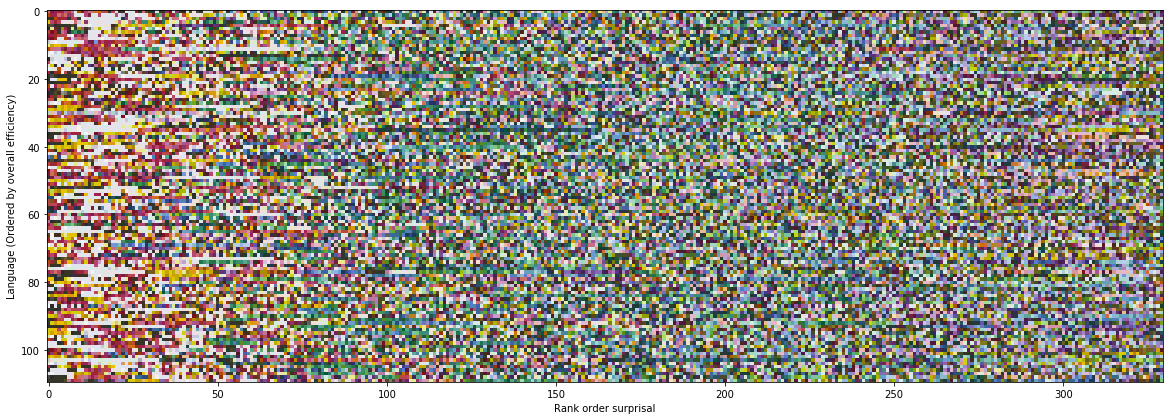

In [13]:
create_rank_order_plot(df_results_cache, rgbs_cache, depth=1)